In [75]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import shutil

In [6]:
good_name_dataset = {
    'bin_2': 'bin4U',
    'bin_5': 'bin3U', 
    'pref': 'pref3U', 
    "enron" : "enron",
    "congress" : "congress",
    "contact" : "contact",
    "dblp": "dblp",
    'aminer': 'aminer'
}
fontsize = 28
labelsize = 20

Effectiveness of Local-Core
---------
`Experiment-1`

In [30]:
# datasets = ["bin_2",  "bin_5", "contact","enron", "congress"]
datasets = ["bin_2",  "bin_5", "contact","enron", "pref", "congress", "dblp", "aminer"]
num_verts = []
wrong_core_numbers = []
wrong_core_perc = []
avg_abserror = []

for data in datasets:
    print(data)
    source_fname = "../output/core_Peel_"+data+".csv"
    target_fname = "../output/wrong_core_"+data+".csv"
    df1 = pd.read_csv(source_fname, header=None)
    df2 = pd.read_csv(target_fname, header=None)

    cnt = 0
    sz = len(df1[0])
    if(len(df1[0])!=len(df2[0])):
        print("Number of vertices do not match")
        exit()
    # print(df1[0])
    # print(sz)
    l1 = [0]*sz
    l2 = [0]*sz

    error = 0
    for i in range(sz):
        if(df1.iat[i,1]!=df2.iat[i,1]):
            cnt+=1
        error += abs(df1.iat[i,1] - df2.iat[i,1])/sz

    num_verts.append(sz)
    wrong_core_numbers.append(cnt)
    wrong_core_perc.append(cnt/sz*100)
    avg_abserror.append(error)

bin_2
bin_5
contact
enron
pref
congress
dblp
aminer


In [31]:
wrong_core_df = pd.DataFrame({'dataset':datasets,'N':num_verts,'#wrongCore':wrong_core_numbers, '%wrongCore':wrong_core_perc})
wrong_core_df = wrong_core_df.replace({"dataset": good_name_dataset})
print(wrong_core_df.head(10)) 

    dataset         N  #wrongCore  %wrongCore
0     bin4U       500         496   99.200000
1     bin3U       500         496   99.200000
2   contact       242         172   71.074380
3     enron      4423        4139   93.579019
4    pref3U    125329        6533    5.212680
5  congress      1718        1657   96.449360
6      dblp   1836596     1623297   88.386177
7    aminer  27850748     2853234   10.244730


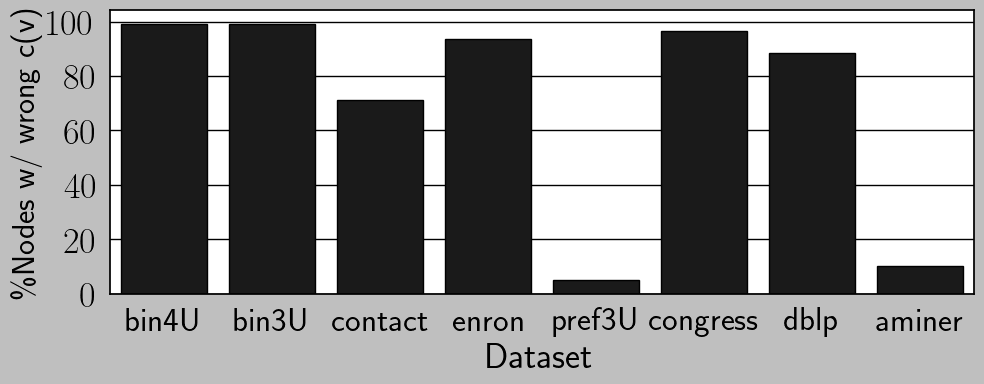

In [61]:
sns.set(rc={'figure.figsize':(10,4)})
sns.set_style("whitegrid", {'axes.grid' : True})
# sns.set_style("ticks")
plt.style.use('grayscale')
plt.rcParams['text.usetex'] = True

sns.barplot(x='dataset', y='%wrongCore', data=wrong_core_df, color='k',hue_order=datasets)
plt.xlabel('Dataset', fontsize=fontsize-2)
plt.xticks(fontsize=fontsize-4)
plt.ylabel('\%Nodes w/ wrong c(v)', fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-2)
plt.tight_layout()
plt.savefig('../fig/WrongCore.pdf')
plt.show()
# plt.xlabel("Iteration", fontsize=fontsize-2)
# plt.ylabel("\%Nodes w/ correct c(v)",fontsize= fontsize-5)
# plt.xticks(fontsize=fontsize-4)
# plt.yticks(fontsize=fontsize-4)

In [33]:
import numpy as np
datalist = ['pref', 'enron', 'bin_5', 'bin_2', 'dblp']
hypH_errors = {}
grH_errors = {}

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "../output/core_Peel_"+data+".csv" # baseline core
    source = "../output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "../output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            target_dict[int(node)] = int(cv) 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1
    # Read graph h-index per iteration
    source_dicts2 = read_iterations_hindices(source2)
    num_iterations_gHindex = len(source_dicts2)+1
#     print(len(source_dicts),' ',len(source_dicts2))

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        error = 0
        for k,val in source_dicts[it].items():
            error += np.abs(val - target_dict[k])
        mean_errors[it] = error/n
    
    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        error = 0
        # #iterations (Gr. h-index) < #iterations (Hyp. hindex) => We replicate the converged iteration state of Graph h-index,
        # because beyond converged iteration all nodes have the same graph h-index.
        if it >= num_iterations_gHindex: 
            mean_errors2[it] = mean_errors2[it-1]
        else:
            for k,val in source_dicts2[it].items():
                error += np.abs(val - target_dict[k])
            mean_errors2[it] = error/n
    
    print('#it(gr): ',num_iterations_gHindex,' #it(hyp):',num_iterations_hypHindex)
    
    hypH_errors[data] = [mean_errors[i] for i in range(1,num_iterations_hypHindex)]
    grH_errors[data] = [mean_errors2[i] for i in range(1, num_iterations_hypHindex)]

pref
#it(gr):  15  #it(hyp): 8
enron
#it(gr):  30  #it(hyp): 11
bin_5
#it(gr):  11  #it(hyp): 9
bin_2
#it(gr):  10  #it(hyp): 10
dblp
#it(gr):  51  #it(hyp): 53


enron


C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\964253128.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".--" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw=3)


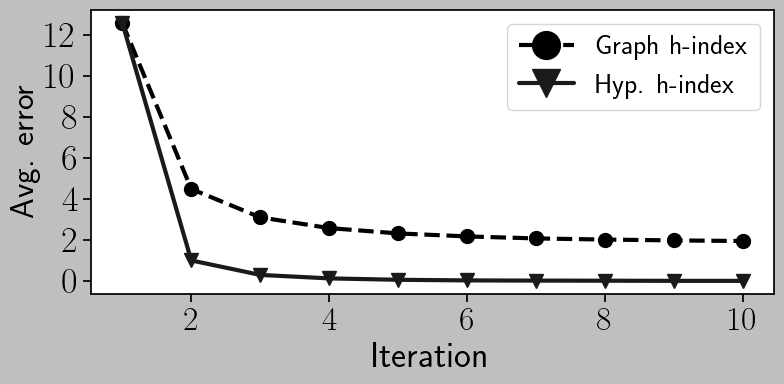

In [59]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
plt.rcParams['text.usetex'] = True

marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]
i = 1
data = datalist[i]
print(good_name_dataset[data])
X = range(1,len(hypH_errors[data])+1)
plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw=3)
plt.plot(X,hypH_errors[data],marker = marker_list[2],color = 'k', markersize = 10,label='Hyp. h-index',lw=3)
# print(Xs[0])
# print(Mean_errors[0])
# print(Mean_errors2[0])
plt.xlabel("Iteration", fontsize=fontsize-2)
plt.ylabel("Avg. error",fontsize= fontsize-4)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-2)
plt.legend(loc = 'best', fontsize=labelsize,markerscale=2)
plt.tight_layout()
plt.savefig('../fig/error_hindex_'+good_name_dataset[data]+'.pdf')
plt.show()

bin4U


C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\2733125307.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".--" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw = 3)


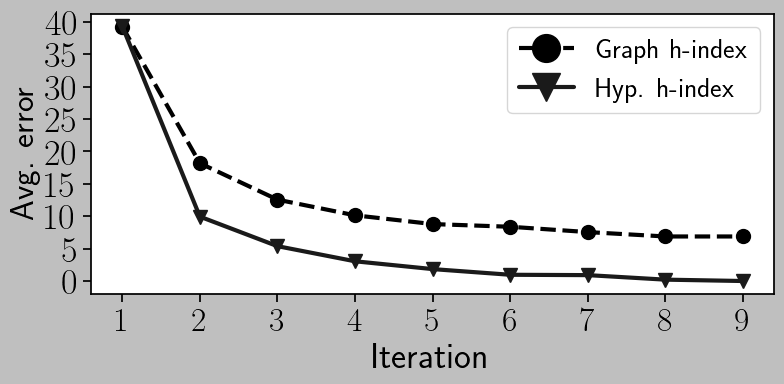

In [58]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
plt.rcParams['text.usetex'] = True
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist)]

i = 3
data = datalist[i] 
print(good_name_dataset[data])
X = range(1,len(hypH_errors[data])+1)
plt.plot(X,grH_errors[data],'.--',marker = marker_list[1], markersize = 10,label='Graph h-index',lw = 3)
plt.plot(X,hypH_errors[data],marker = marker_list[2],color = 'k', markersize = 10,label='Hyp. h-index',lw = 3)


plt.xlabel("Iteration", fontsize=fontsize-2)
plt.ylabel("Avg. error",fontsize= fontsize-4)
# plt.yscale('log')
# plt.title(good_name_dataset[data])
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-2)
plt.legend(loc = 'best', fontsize=labelsize,markerscale=2)
plt.tight_layout()
plt.savefig('../fig/error_hindex_'+good_name_dataset[data]+'.pdf')
plt.show()
# plt.xlabel("Iteration", fontsize=fontsize-2)
# plt.ylabel("\%Nodes w/ correct c(v)",fontsize= fontsize-5)
# plt.xticks(fontsize=fontsize-4)
# plt.yticks(fontsize=fontsize-4)

`Experiment-2`

In [36]:
datalist = ['pref', 'enron', 'bin_5','bin_2','dblp']
Xs = {}
Ys = {} 

def read_iterations_hindices(source):
    source_dicts = {}
    with open(source,'r') as f:
        nodes = []
        i = 0
        for line in f.readlines():
            # line = line.strip()
            if i==0:
                line = line.split(",")
                line = line[:-1]
                for l in line:
                    nodes.append(int(l))
            else:
                source_dicts[i] = {}
                line = line.split(",")
                line = line[:-1]
                for node,l in zip(nodes,line):
                    cv = int(l)
                    source_dicts[i][node] = cv
            i+=1
    return source_dicts

for data in datalist: 
    print(data)
    target = "../output/core_Peel_"+data+".csv" # baseline core
    source = "../output/log_Local-core_"+data+".csv" # hypergraph h-index
    source2 = "../output/wrong_core_log_"+data+".csv" # graph h-index
    target_dict = {} # baseline
    source_dicts = {} # hyp h-index
    source_dicts2 = {} # graph h-index
    correct_perc = {} # % correct core-number at iteration i (hyp h-index)
    mean_errors = {}
    mean_errors2 = {}
    # Read baseline core
    with open(target,'r') as f:
        for line in f.readlines():
            node,cv = line.split(',')
            node = int(node)
            cv = int(cv)
            target_dict[node] = cv 
    
    # Read hyp h-index per iteration
    source_dicts = read_iterations_hindices(source)
    num_iterations_hypHindex = len(source_dicts)+1

    for it in range(1,num_iterations_hypHindex):
        n = len(target_dict)
        num_cor = 0
        for k,val in source_dicts[it].items():
            if val == target_dict[k]:
                num_cor+=1
        correct_perc[it] = (num_cor * 100.0)/n
    
    Xs[data] = sorted(list(correct_perc.keys()))
    Ys[data] = [correct_perc[i] for i in Xs[data]]

pref
enron
bin_5
bin_2
dblp


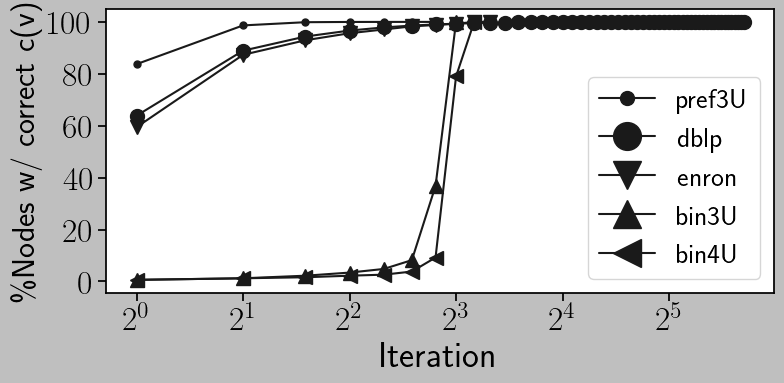

In [57]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
plt.rcParams['text.usetex'] = True

datalist2 = ['pref', 'dblp', 'enron','bin_5','bin_2']
# datalist2 = datalist[:5]
# marker_list = list(Line2D.markers)
marker_list = [list(Line2D.markers)[0]] + list(Line2D.markers)[2:1+len(datalist2)]
for i,data in enumerate(datalist2):
    plt.plot(Xs[data],Ys[data],label=good_name_dataset[data],marker = marker_list[i], color = 'k', markersize = 10)
plt.xscale('log',base=2)
plt.xlabel("Iteration", fontsize=fontsize-2)
plt.ylabel("\%Nodes w/ correct c(v)",fontsize= fontsize-5)
plt.xticks(fontsize=fontsize-4)
plt.yticks(fontsize=fontsize-4)
plt.legend(loc = 'lower right', fontsize=labelsize,markerscale=2)
# plt.legend(loc = 'lower right', fontsize=labelsize-4,markerscale=1,mode = "expand", ncol = 2)
plt.tight_layout()
plt.savefig('../fig/Convergence.pdf')
plt.show()

Efficiency Evaluation and 
`Experiment-3`
-------

In [895]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import os
import shutil

output_folder = '../output/'
parallel_outfolder = '../output/parout/'
fontsize = 28
labelsize = 20

In [19]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset',  'execution time', 'init time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"bresults.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time','init time',  "num_threads", "total iteration"]
df2 = df2[df2.num_threads == 64].copy()
df = pd.concat([df1,df2])
print(df.shape)
print(df.dataset.unique())
df.head()
dfT = df.copy()
dfT['total'] = dfT['execution time']+dfT['init time']

(98, 6)
['bin_2' 'bin_5' 'contact' 'congress' 'enron' 'dblp' 'pref' 'aminer'
 'protein']


In [409]:
# dfT

In [9]:
good_name = {
    'bucket update time' : 'Bucket time (s)', 
    'execution time' : "Execution time (s)", 
    'neighborhood call time' : "NB time (s)", 
    'subgraph computation time' : "Sub time(s)",
    'num bucket update' : "#bucket", 
    'num neighborhood computation' : "#nb",
    'num subgraph call' : "#subgraph",
    'outerloop time': "outloop time(s)",
    'init time': 'init time(s)',
    'total iteration': '#total iterations',
    'inner iteration': '#inner iterations',
    'memory taken': 'Memory (MB)',
    'core_correction time': 'Core-corection time(s)',
    'h_index_time': 'h-index time(s)',
    'sum_core_correction_volume' : 'Sum Core-correction vol',
    'tau': '#Iterations'
    # 'num_threads' : '#Threads'
}

# NBR(1) adopts Arijits simplification to Bishwa's simplification.
good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local+I",
    'Local-core-OPTII': "Local+I+II",
    'Local-core-OPTIII': "Local+I+II+III",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)",
    'kdcore': '(k,d)-core',    
    'clique': 'cliqueG-Local',
    'bipartite': 'D2biparatiteG-Local'
}

good_name_dataset = {
    'bin_2': 'bin4U',
    'bin_5': 'bin3U', 
    'pref': 'pref3U', 
    "enron" : "enron",
    "congress" : "congress",
    "contact" : "contact",
    "dblp": "dblp",
    'aminer': 'aminer'
}
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
hatch_dict = {
    'Peel' : "//", 
    'E-Peel': "///", 
    'Local-core': "\\\\",
    'Local-core-OPTI': "\\\\",
    'Local-core-OPTII': "\\\\",
    'Local-core-OPTIII': "\\\\",
    'Local-core-OPTIV': "\\\\",
    'LocalP(B+CSR)2': "OO",
    'kdcore': '..',
    'clique': 'xx',
    'bipartite': '++'
}
order=["Peel", "E-Peel", "Local-core-OPTIV"]
# order=["Peel", "E-Peel", "Local-I","Local-II","Local-III"]
linewidth= 2
scatterplotBall = 150
save = True

In [15]:
def drawlarge():
    import matplotlib.pyplot as plt 
    import seaborn as sns 
    import itertools
    import matplotlib
    sns.set(rc={'figure.figsize':(8,4)})
    sns.set_style("dark", {'axes.grid' : True})
    # sns.set_style("ticks")
    plt.style.use('grayscale')
    plt.rcParams['text.usetex'] = True

    markers = ['o',"s",'x']
    include_algos = ["clique", "bipartite", "Peel", "E-Peel", "Local-core-OPTIV", 'LocalP(B+CSR)2']
    ord = [good_name_algo[i] for i in include_algos]
    h = itertools.cycle([hatch_dict[i] for i in include_algos])
    group_list = ['dataset']
    
    include_datasets = ['pref','congress','dblp','aminer']
    # include_datasets = ['congress','dblp', 'aminer']
    # columns = ['execution time']

    working_df = dfT[dfT['dataset'].isin(include_datasets)].copy()
    working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # working_df = working_df[working_df['num_threads']==1].copy()
    # working_df = working_df[working_df['num_threads']==1].copy()
    working_df = working_df.replace({"algo": good_name_algo})
    working_df = working_df.replace({"dataset": good_name_dataset})
    include_datasets = [good_name_dataset[d] for d in include_datasets]
    ax = sns.barplot(x='dataset', y='total', hue='algo', data=working_df, hue_order = ord, order = include_datasets, ci = None, color='k')
    ax.get_legend().remove()
    for i,thisbar in enumerate(ax.patches):
        thisbar.set_facecolor('k')
    y_axis = 'execution time'  
    # print(working_df)
    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # _min = working_df[y_axis].min()
    # donotdrawline = working_df[y_axis].max() <= 20*_min
    # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets, color = 'w',ci=None)
    # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets, color='k')
    # ax = sns.catplot(x='dataset', y='execution time', hue='algo', data=working_df, kind='bar', order = include_datasets, color='k')
    # plt.bar(working_df['dataset'], working_df['init time'],edgecolor='black', hatch="/")
    # plt.bar(working_df['dataset'], working_df['execution time'])

    for i,thisbar in enumerate(ax.patches):
        if i%len(include_datasets)==0:
            hatch = next(h)
        thisbar.set_hatch(hatch)
        # thisbar.set_facecolor('white')

    plt.xlabel('Dataset', fontsize=fontsize)
    plt.ylabel('E2E Time(s)', fontsize=fontsize-2)
    plt.yscale("log")
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    # plt.ylim(np.min(working_df['execution time'].values)/10,np.max(working_df['execution time'].values)*10+1)
    ax.set_yticks([0.01, 10**0, 10**1, 10**2,10**4, 10**6])
    # ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    # plt.title()
    # plt.legend(loc = 'upper left', fontsize=labelsize-4, mode = "expand", ncol = 4) # ,bbox_to_anchor =(0.65, 1.25), mode = "expand", ncol = 3
    # plt.legend(fontsize=labelsize)
    # ax.get_legend().remove()
    label_params = ax.get_legend_handles_labels()
    x,y = label_params
    x= x[len(include_algos):]
    y= y[len(include_algos):]
    ax.get_legend().remove()
    # ax.legend(*(x,y),loc='upper center', bbox_to_anchor=(0.4, 1.6), ncol=3, fontsize = labelsize-3)


    plt.tight_layout()
    filename = ("revisedlarge " + y_axis).replace(" ", "_")
    if(save):
        plt.savefig("../fig/" + filename + ".pdf")
        plt.show()
    else:
        print(filename)
        plt.show()
    plt.clf()
    return label_params

# print(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.2)

def drawsmall():
    import matplotlib.pyplot as plt 
    import seaborn as sns 
    import itertools

    sns.set(rc={'figure.figsize':(8,4)})
    sns.set_style("dark", {'axes.grid' : True})
    # sns.set_style("ticks")
    plt.style.use('grayscale')
    plt.rcParams['text.usetex'] = True
    
    markers = ['o',"s",'x']
    include_algos = ["clique", "bipartite", "Peel", "E-Peel", "Local-core-OPTIV", 'LocalP(B+CSR)2']
    ord = [good_name_algo[i] for i in include_algos]
    h = itertools.cycle([hatch_dict[i] for i in include_algos])
    group_list = ['dataset']
    
    include_datasets = ['bin_2','bin_5','contact','enron']
    # columns = ['execution time']
    working_df = dfT[dfT['dataset'].isin(include_datasets)].copy()
    working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # working_df['param_s'] = working_df['param_s'].astype(int)
    working_df = working_df.replace({"algo": good_name_algo})
    working_df = working_df.replace({"dataset": good_name_dataset})
    include_datasets = [good_name_dataset[d] for d in include_datasets]
    y_axis = 'execution time'  

    ax = sns.barplot(x='dataset', y='total', hue='algo', data=working_df, hue_order = ord, order = include_datasets, color='k',ci=None)
    ax.get_legend().remove()
    for i,thisbar in enumerate(ax.patches):
        thisbar.set_facecolor('k')
    y_axis = 'execution time'  
    # print(working_df)

    ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='w',ci=None)

    for i,thisbar in enumerate(ax.patches):
        if i%len(include_datasets)==0:
            hatch = next(h)
        thisbar.set_hatch(hatch)
        # thisbar.set_facecolor('white')
        
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    # plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*2)

    plt.xlabel('Dataset', fontsize=fontsize)
    plt.ylabel('E2E Time(s)', fontsize=fontsize-2)
    plt.yscale("log")
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)
    # print(plt.yticks())
    ax.set_yticks([10**(-3),10**(-2), 10**(-1), 10**0, 10**2])


    label_params = ax.get_legend_handles_labels()
    x,y = label_params
    x= x[len(include_algos):]
    y= y[len(include_algos):]
    ax.get_legend().remove()
    # ax.legend(*(x,y),loc='upper center', bbox_to_anchor=(0.4, 1.6), ncol=3, fontsize = labelsize-3)
    plt.tight_layout()
    filename = ("revisedsmall " + y_axis).replace(" ", "_")
    if(save):
        plt.savefig("../fig/" + filename + ".pdf")
        plt.show()
    else:
        print(filename)
        plt.show()
    plt.clf()
    return label_params

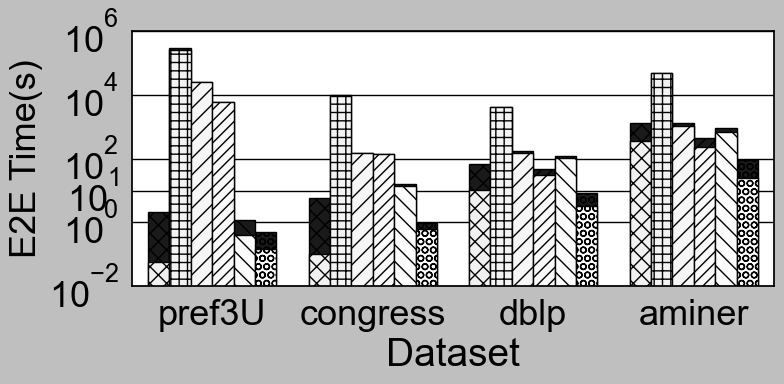

<Figure size 800x400 with 0 Axes>

In [677]:
_ = drawlarge()

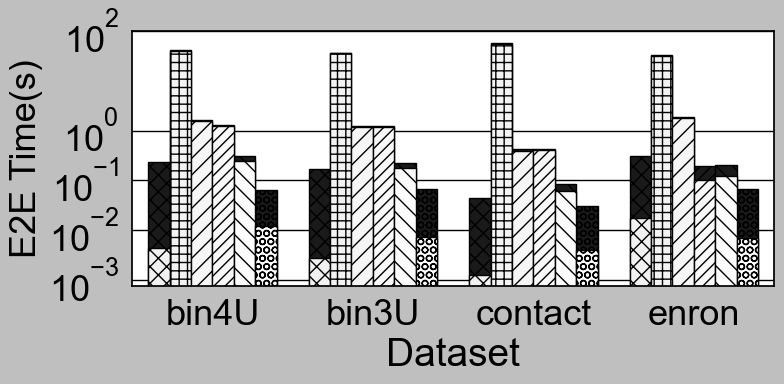

<Figure size 800x400 with 0 Axes>

In [676]:
_ = drawsmall()

`Experiment-4: Efficiency & Impact of optimizations`

In [1]:
save = True
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_opt():    
    import matplotlib.cm
    import matplotlib.pyplot as plt 
    # from matplotlib.ticker import MaxNLocator
    import seaborn as sns 
    sns.set(rc={'figure.figsize':(7,4)})
    sns.set_style("dark", {'axes.grid' : True})
    # sns.set_style("ticks")
    plt.style.use('grayscale')

    good_name_algo = {
        'Local-core': "Local-core",
        'Local-core-OPTI': "Local-core+I",
        'Local-core-OPTII': "Local-core+I+III",
        'Local-core-OPTIII': "Local-core+I+III+IV",
        'Local-core-OPTIV': "Local-core+I+III+IV+II",
    }

    include_algos = ['Local-core', 'Local-core-OPTI','Local-core-OPTII', 'Local-core-OPTIII', 'Local-core-OPTIV']
    ord = [good_name_algo[i] for i in include_algos]
    group_list = ['dataset']
    # include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
    include_datasets = ['enron','congress','dblp', 'aminer']
    # columns = ['execution time']

    working_df = df[df['dataset'].isin(include_datasets)].copy()
    working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    working_df = working_df[working_df['num_threads']==1].copy()
    # working_df['param_s'] = working_df['param_s'].astype(int)
    working_df = working_df.replace({"algo": good_name_algo})
    working_df = working_df.replace({"dataset": good_name_dataset})
    include_datasets = [good_name_dataset[d] for d in include_datasets]
    y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # _min = working_df[y_axis].min()
    # donotdrawline = working_df[y_axis].max() <= 20*_min
    # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] ) 

    cmap = plt.get_cmap('gray')
    new_cmap = truncate_colormap(cmap, 0.35, 1)
    matplotlib.cm.register_cmap("mycolormap", new_cmap)

    ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,\
                     palette = sns.color_palette("mycolormap"))
    for i,thisbar in enumerate(ax.patches):
        thisbar.set_hatch(hatch_dict['Local-core'])
        if ((i+1)>16):
        #     # print(i+1)
            thisbar.set_facecolor('w')
    plt.xlabel('Dataset', fontsize=fontsize-2)
    plt.ylabel('Alg. Time(s)', fontsize=fontsize-3)
    plt.yscale("log")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize-3)
    # plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)
    
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    # plt.ylim(np.min(working_df['execution time'].values)/10,np.max(working_df['execution time'].values)*10+1)
    ax.set_yticks([0.01, 10**0,10**-1, 10**1,10**2,10**4])
    
    # plt.title()
    # plt.legend(loc = 'upper left', fontsize=labelsize-2, bbox_to_anchor=(-0.01,1.02))
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #           fancybox=True, shadow=True, ncol=5)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.1), ncol=3, fontsize=labelsize-2)
    label_params = ax.get_legend_handles_labels()
    x,y = label_params
    x= x[len(include_algos):]
    y= y[len(include_algos):]
    ax.get_legend().remove()

    # plt.legend(*label_params, loc='upper center', bbox_to_anchor=(0.4, 1.6), ncol=3, fontsize = labelsize-4)

    plt.tight_layout()
    filename = ("revisedlarge " + y_axis).replace(" ", "_")
    if(save):
        plt.savefig("../fig/" + filename + "_opt.pdf")
        plt.show()
    else:
        print(filename)
        plt.show()
    plt.clf()
    matplotlib.cm.unregister_cmap("mycolormap")
    return label_params

`Expteriment-6: Efficiency of Local-core+Peel for (k, d)-core decomposition`

In [17]:
save = True
def plot_kd():    
    import matplotlib.pyplot as plt 
    # from matplotlib.ticker import MaxNLocator
    import seaborn as sns
    import itertools
    sns.set(rc={'figure.figsize':(7,4)})
    sns.set_style("dark", {'axes.grid' : True})
    # sns.set_style("ticks")
    plt.style.use('grayscale')
    plt.rcParams['text.usetex'] = True

    good_name_algo2 = {
        'Local-core-OPTIV': "Local-core(OPT)",
        'kdcore': "Local-core+Peel for (k,d)-core"
    }

    include_algos = ['kdcore', 'Local-core-OPTIV']
    h = itertools.cycle([hatch_dict[i] for i in include_algos])


    ord = [good_name_algo2[i] for i in include_algos]
    group_list = ['dataset']
    # include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
    include_datasets = ['pref','congress','dblp', 'aminer']
    # columns = ['execution time']

    working_df = df[df['dataset'].isin(include_datasets)].copy()
    working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    working_df = working_df[working_df['num_threads']==1].copy()
    # working_df['param_s'] = working_df['param_s'].astype(int)
    working_df = working_df.replace({"algo": good_name_algo2})
    working_df = working_df.replace({"dataset": good_name_dataset})
    include_datasets = [good_name_dataset[d] for d in include_datasets]
    y_axis = 'execution time'  
    # print(working_df)
    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # _min = working_df[y_axis].min()
    # donotdrawline = working_df[y_axis].max() <= 20*_min
    # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    # print(working_df)
    ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df,  order = include_datasets, hue_order = ord, color='k',ci = None)
    # 
    for i,thisbar in enumerate(ax.patches):
        if i%len(include_datasets)==0:
            hatch = next(h)
        thisbar.set_hatch(hatch)
        thisbar.set_facecolor('w')
        
    plt.xlabel('Dataset', fontsize=fontsize-2)
    plt.ylabel('Alg. Time(s)', fontsize=fontsize-3)
    plt.yscale("log")
    plt.xticks(fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-3)
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    ax.set_yticks([0.1, 10**0, 10**1,10**2,10**3,10**4])
    
    # plt.ylim(np.min(working_df[y_axis].values)/10,np.max(working_df[y_axis].values)*1.1)
    # plt.title()
    # plt.legend(loc = 'upper left', fontsize=labelsize-2, bbox_to_anchor=(-0.01,1.02))
    # plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
    #           fancybox=True, shadow=True, ncol=5)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # plt.legend(loc='upper center', bbox_to_anchor=(0.4, 1.1), ncol=3, fontsize=labelsize-2)
    label_params = ax.get_legend_handles_labels()
    # x,y = label_params
    # x= x[len(include_algos):]
    # y= y[len(include_algos):]
    ax.get_legend().remove()

    # plt.legend(*label_params, loc='upper center', bbox_to_anchor=(0.4, 1.6), ncol=3, fontsize = labelsize-4)
    plt.tight_layout()
    filename = ("kdlarge " + y_axis).replace(" ", "_")
    if(save):
        plt.savefig("../fig/" + filename + ".pdf")
        plt.show()
    else:
        print(filename)
        plt.show()
    plt.clf()
    return label_params
# _=plot_kd()

`Plotting legends`

C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\973336973.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dataset', y='total', hue='algo', data=working_df, hue_order = ord, order = include_datasets, color='k',ci=None)
C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\973336973.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets,color='w',ci=None)


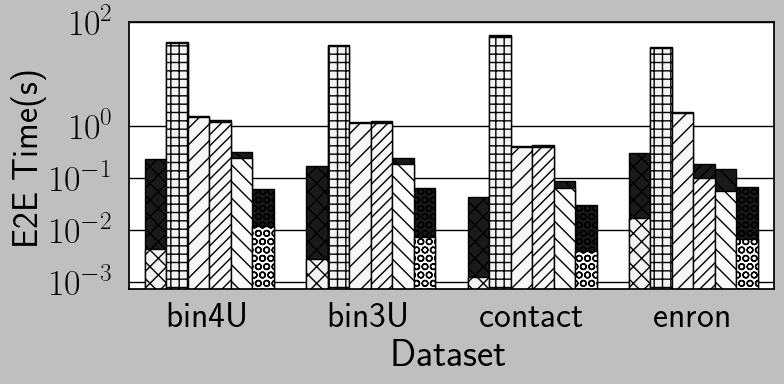

C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\973336973.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dataset', y='total', hue='algo', data=working_df, hue_order = ord, order = include_datasets, ci = None, color='k')
C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\973336973.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, hue_order = ord, order = include_datasets, color = 'w',ci=None)


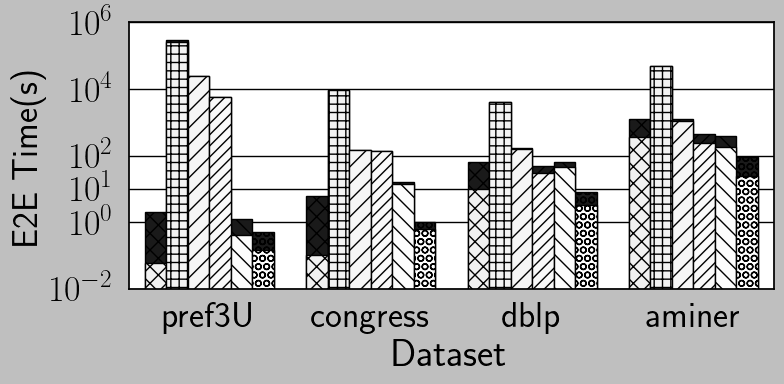

C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\62685883.py:51: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  matplotlib.cm.register_cmap("mycolormap", new_cmap)


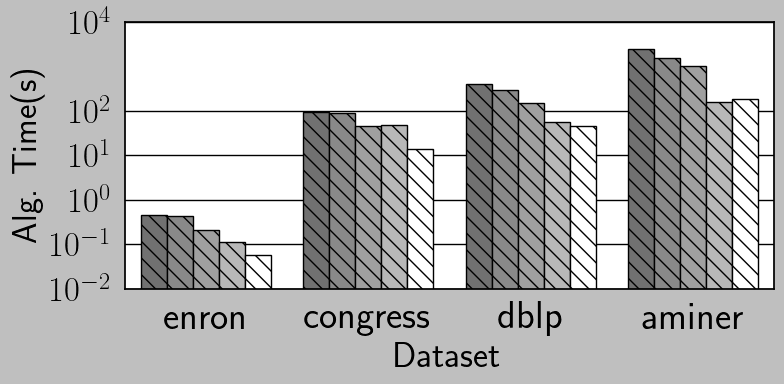

C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\62685883.py:95: MatplotlibDeprecationWarning: The unregister_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.unregister(name)`` instead.
  matplotlib.cm.unregister_cmap("mycolormap")
C:\Users\naheedanjum.arafat\AppData\Local\Temp\ipykernel_19560\649081655.py:42: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df,  order = include_datasets, hue_order = ord, color='k',ci = None)


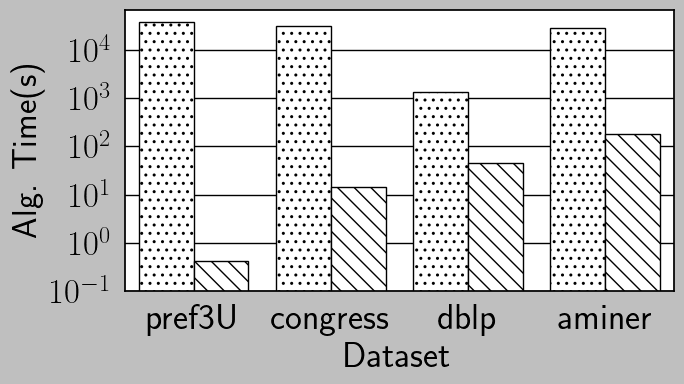

([<BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>, <BarContainer object of 4 artists>], ['cliqueG-Local', 'D2biparatiteG-Local', 'Peel', 'E-Peel', 'Local-core(OPT)', 'Local-core(P)', 'Local-core', 'Local-core+I', 'Local-core+I+III', 'Local-core+I+III+IV', 'Local-core+Peel for (k,d)-core'])


<Figure size 700x400 with 0 Axes>

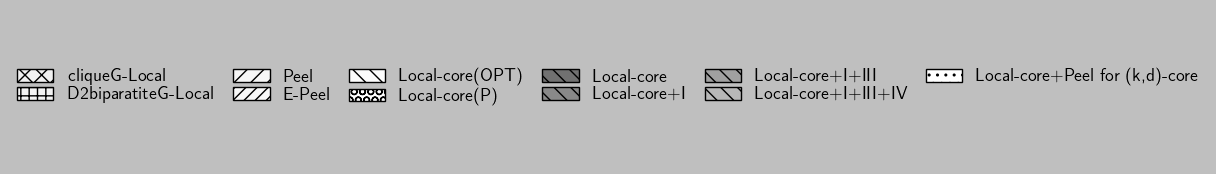

In [20]:
def plot_legend(dr_sm,opt_params,kd_params):
    # _tmp = label_params[0] + label_params2[0]; 
    # print(type(label_params[0]))
    # _tmpp = label_params[1] + label_params2[1]
    # label_params = (_tmp,_tmpp)
    # print(dr_sm)
    figl, axl = plt.subplots(figsize=(14,2))
    axl.axis(False)
    # x = dr_sm[0][6:]
    # y = dr_sm[1][6:]
    # print(dr_sm)
    # print(opt_params)
    # print('---')

    # p = ( dr_sm[0][6:] + opt_params[0][1:len(opt_params[0])-1], dr_sm[1][6:] + opt_params[1][1:len(opt_params[0])-1])
    p = ( dr_sm[0][6:] + opt_params[0][:-1] +kd_params[0][:-1], \
         dr_sm[1][6:] + opt_params[1][:-1] +kd_params[1][:-1])
    print(p)
    axl.legend(*p, loc="center", bbox_to_anchor=(0.5, 0.5), prop={"size":13}, frameon = False, framealpha = 1, fancybox = False,\
               ncol=len(p[1])//2+1, fontsize = labelsize, labelspacing = 0.1, columnspacing = 1)
    plt.savefig('../fig/legends.pdf'); plt.show()
dr_sm = drawsmall()
# print(dr_sm)
dr_la = drawlarge()
opt_params = plot_opt()
kd_params = plot_kd()
plot_legend(dr_la,opt_params,kd_params)

`Experiment-5 (Impact of Parallelization)`

In [1]:
import pandas as pd
output_folder = '../output/'
parallel_outfolder = '../output/parout/'
fontsize = 28
labelsize = 20
good_name_algo = {
    'Peel' : "vs. Peel", 
    'E-Peel': "vs. E-Peel", 
    'Local-core': "Local",
    'Local-core-OPTI': "Local(I)",
    'Local-core-OPTII': "Local(II)",
    'Local-core-OPTIII': "Local(III)",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)"
}

In [2]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time','init time', "num_threads", "total iteration"]
df2 = pd.read_csv(parallel_outfolder+"inresults.csv", header = None)
df2.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
df = pd.concat([df1,df2])
# df3 = pd.read_csv(parallel_outfolder+"inresults.csv", header = None)
# df3.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
# df.tail(10)

dblp


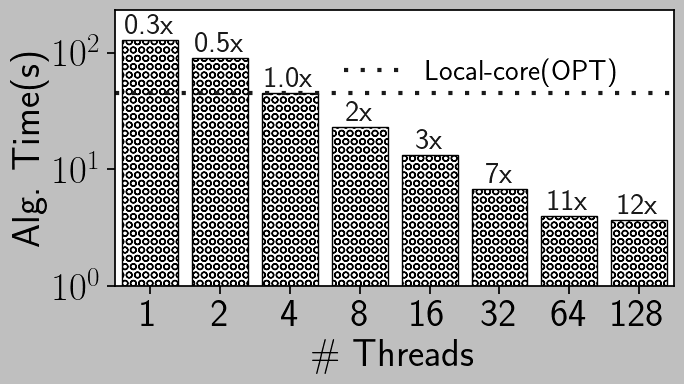

aminer


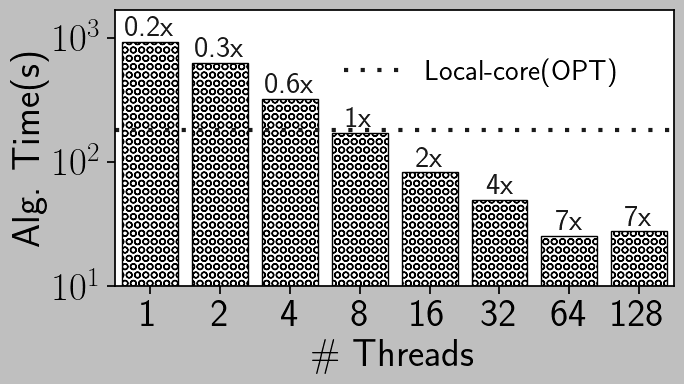

pref3U


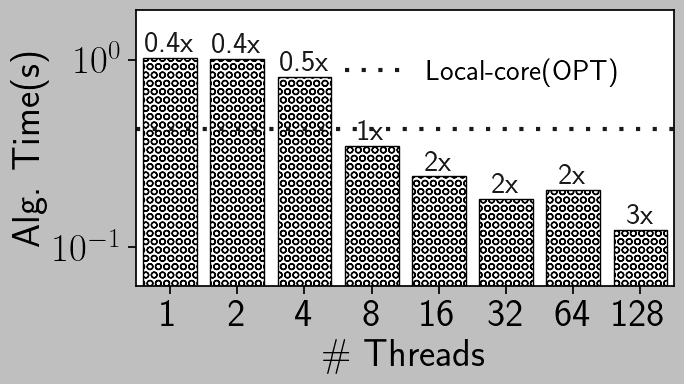

congress


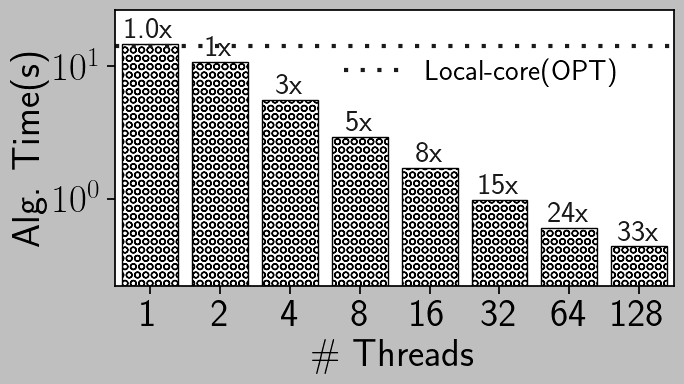

<Figure size 700x400 with 0 Axes>

In [13]:
# from matplotlib import pyplot as plt 
# # from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
# sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("dark", {'axes.grid' : False})
# # sns.set_style("ticks")
# plt.style.use('grayscale')
import numpy as np
import matplotlib.pyplot as plt 
# from matplotlib.ticker import MaxNLocator
import seaborn as sns
import itertools
sns.set(rc={'figure.figsize':(7,4)})
sns.set_style("dark", {'axes.grid' : False})
sns.set_style("ticks")
plt.style.use('grayscale')
plt.rcParams['text.usetex'] = True
save = True

include_algos = ['LocalP(B+CSR)2']
reference_algs = ['Local-core-OPTIV'] # Reference against.
col = ['r','g','b']
markers = ['o',"s",'x']
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
# include_datasets = ['bin_2','bin_5','contact','enron', 'congress']
# include_datasets = ['congress','dblp', 'aminer', 'gowalla','pref']
include_datasets = ['dblp', 'aminer', 'pref', 'congress']
# include_datasets = ['gowalla']
# columns = ['execution time']

tmp = df[df['dataset'].isin(include_datasets)].copy()
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df = working_df.replace({"dataset": good_name_dataset})
include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  

graph = None
df4 = tmp[tmp['algo'].isin(reference_algs)].copy()
df4 = df4.replace({"dataset": good_name_dataset})
thread_lim = 8
for dp in include_datasets:
    print(dp)
    for i,alg in enumerate(reference_algs):
        ref_mean = df4[ (df4.algo == alg) & (df4.dataset==dp)]['execution time'].mean()
        # print(df4[ (df4.algo == alg) & (df4.dataset==dp)])
        working_df2 = working_df[working_df.dataset == dp].copy()
        # print(working_df2[y_axis])
        working_df2['speedup']  = ref_mean/ working_df2[y_axis]
        if len(working_df2)==0:
            continue 
        # print(working_df2)
        # print(working_df2)
        # print(working_df2.groupby(['num_threads'])['execution time'].mean())
        # _min = working_df[y_axis].min()
        # donotdrawline = working_df[y_axis].max() <= 20*_min
        # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
        ax = sns.barplot(x='num_threads', y=y_axis, data=working_df2, color='k')
        # graph = sns.scatterplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # sns.lineplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind', marker = markers[i], label = alg)
        # plt.plot(working_df2['num_threads'][:thread_lim], working_df2[y_axis][:thread_lim],marker = markers[i], label = good_name_algo[alg],color = 'k')
        labs = []
        for i,v in enumerate(working_df2['num_threads'][:thread_lim]):
            sp = ref_mean/ working_df2[y_axis][:thread_lim].values[i]
            if sp<1:
                speedup = "{:.1f}x".format(sp)
            else:
                speedup = "{:.0f}x".format(sp)
            labs.append(speedup)
            # print(working_df2[y_axis][:thread_lim].values[i], speedup)
            # plt.text(v-working_df2['num_threads'][:thread_lim].values[i], working_df2[y_axis][:thread_lim].values[i]*1.1,str(speedup) , \
            #          color='k', fontweight='bold',fontsize = fontsize-6)
            # plt.text(v, working_df2[y_axis][:thread_lim].values[i], str(speedup) , color='k', fontweight='bold',fontsize = fontsize-6)
            # ax.text(v, working_df2[y_axis][:thread_lim].values[i], speedup, color='black', ha="center")
        ax.bar_label(ax.containers[0],labels = labs,color='k',fontsize=fontsize-6, fontweight='bold')
            # print(v, working_df2[y_axis][:thread_lim].values[i])
        for i,thisbar in enumerate(ax.patches):
            thisbar.set_hatch(hatch_dict['LocalP(B+CSR)2'])
            thisbar.set_facecolor('w')
            
        
        # plt.bar(x = working_df2['num_threads'][:thread_lim], height = working_df2[y_axis][:thread_lim], width = working_df2['num_threads'][:thread_lim]/4, alpha = 0.6)
        # ax = plt.gca()
        # ax.get_yaxis().set_tick_params(which='minor', size=0)
        # ax.get_yaxis().set_tick_params(which='minor', width=0) 
        # ax.set_yticks([10**(-1), 10**(0), 10**1,10**2])
        # for i,v in enumerate(working_df2['num_threads'][:thread_lim]):
        #     sp = ref_mean/ working_df2[y_axis][:thread_lim].values[i]
        #     if sp<1:
        #         speedup = "{:.1f}x".format(sp)
        #     else:
        #         speedup = "{:.0f}x".format(sp)
        #     # print(working_df2[y_axis][:thread_lim].values[i], speedup)
        #     plt.text(v-working_df2['num_threads'][:thread_lim].values[i]/5, working_df2[y_axis][:thread_lim].values[i]*1.1,str(speedup) , \
        #              color='k', fontweight='bold',fontsize = fontsize-6)
        # for i,thisbar in enumerate(ax.patches):
        #     thisbar.set_hatch(hatch_dict['LocalP(B+CSR)2'])
        #     thisbar.set_facecolor('w')
            

        plt.axhline(ref_mean,color = 'k',linestyle = '--',dashes=(1, 3), label = good_name_algo[alg],linewidth = 3)
        plt.xlabel('\# Threads', fontsize=fontsize)
        # plt.ylabel("Speedup", fontsize=fontsize)
        plt.ylabel('Alg. Time(s)', fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks( fontsize=fontsize)
        plt.yscale("log", base = 10)
        # plt.xscale("log", base = 2)
        # plt.title(dp)
    
    plt.legend(loc = 'upper right', fontsize=labelsize+1, frameon = False, framealpha = 1, fancybox = False,bbox_to_anchor = (0.95,0.92))
    plt.ylim(np.min(working_df2[y_axis][:thread_lim].values)/2, np.max(working_df2[y_axis][:thread_lim].values)*1.8)
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    if dp=='dblp':
        ax.set_yticks([10**(0), 10**1,10**2])
    if dp=='aminer':
        ax.set_yticks([10**1, 10**2,10**3])
    plt.tight_layout()
    filename = "parallel_time_"+dp
    if(save):
        plt.savefig("../fig/" + filename + ".pdf")
    else:
        print(filename)
    plt.show()
    plt.clf() 
        

    # include_datasets = ['bin_2','bin_5','contact','enron']
    # # columns = ['execution time']
    # working_df = df[df['dataset'].isin(include_datasets)].copy()
    # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # # working_df['param_s'] = working_df['param_s'].astype(int)
    # # working_df = working_df.replace({"algo": good_name_algo})
    # working_df = working_df.replace({"dataset": good_name_dataset})
    # include_datasets = [good_name_dataset[d] for d in include_datasets]
    # y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # # _min = working_df[y_axis].min()
    # # donotdrawline = working_df[y_axis].max() <= 20*_min
    # # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
    # ax.yaxis.set_major_locator(MaxNLocator(5)) 
    # plt.xlabel('Dataset', fontsize=fontsize)
    # plt.ylabel(good_name[y_axis], fontsize=fontsize)
    # # plt.yscale("log")
    # plt.xticks(fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    # # plt.
    # # ()
    # plt.legend(loc = 'upper center', bbox_to_anchor=(0.6,1), fontsize=labelsize-6)
    # plt.tight_layout()
    # filename = ("small " + y_axis).replace(" ", "_")
    # if(save):
    #     plt.savefig("results_final/fig/" + filename + ".pdf")
    # else:
    #     print(filename)
    #     plt.show()
    # plt.clf()


Extra Experiments
------

``Local-core(p): With openmp dynamic-scheduling vs without``

In [865]:
df1 = pd.read_csv(output_folder+"results.csv", header = None)
df1.columns = ['algo', 'dataset', 'execution time','init time', "num_threads", "total iteration"]
df2 = pd.read_csv('../output/parout/inresults.csv', header = None)
df2.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
# df = pd.concat([df1,df2])
df = df2
# df = df[df.num_threads<128]
# df.head()
print(len(df))

df3 = pd.read_csv("../output/parout/inresults_dy.csv", header = None)
df3.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
df4 = df3.copy()
df4.algo = 'Local(P)+dS'
# df4 = df4[df4.num_threads<128]
# print(df4.tail())
# print('----')
df_tmp = df1[df1.algo=='Local-core-OPTIV']
# dff = pd.concat([df_tmp,df4])
dff = df4.copy() # localp+dS
print(len(dff))

64
71


dblp
Local-core-OPTIV
8   8
[136.21056   81.710304  45.24335   24.459347  14.122804   7.867111
   4.122569   3.636917]
[128.678776  89.397065  45.175879  23.185389  13.260693   6.82647
   3.973257   3.699277]


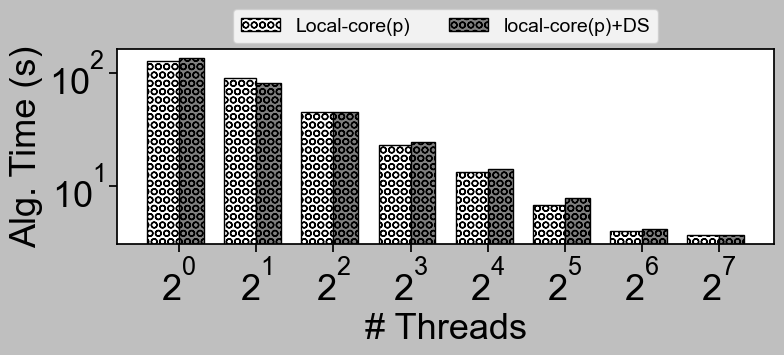

aminer
Local-core-OPTIV
8   8
[987.459436 635.679281 342.311201 187.381472 102.12579   56.871299
  37.696168  39.098063]
[925.775171 623.571561 320.690847 170.390753  82.357461  49.148092
  25.289398  27.637363]


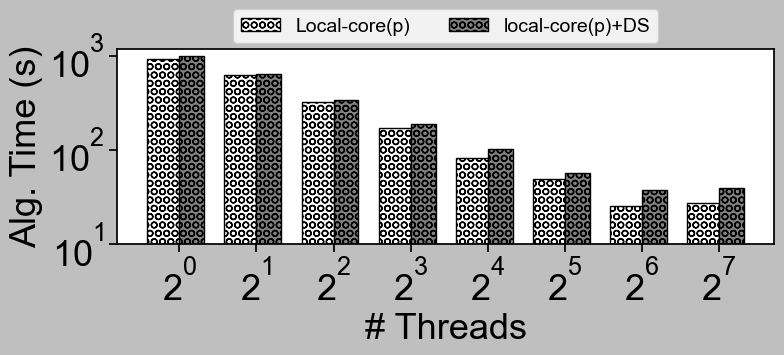

pref3U
Local-core-OPTIV
8   8
[1.179535 0.904845 0.352982 0.268912 0.377597 0.389621 0.243566 0.28565 ]
[1.027329 1.013452 0.814897 0.349388 0.239239 0.182388 0.202774 0.124002]


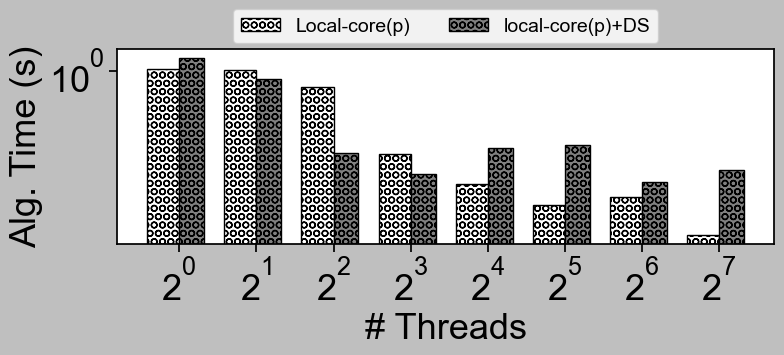

enron
Local-core-OPTIV
8   13
[0.007989 0.094101 0.087772 0.127907 0.09121  0.177833 0.110093 0.056391]
[0.153113 0.111129 0.056984 0.029855 0.016977 0.010238 0.025344 0.02561 ]


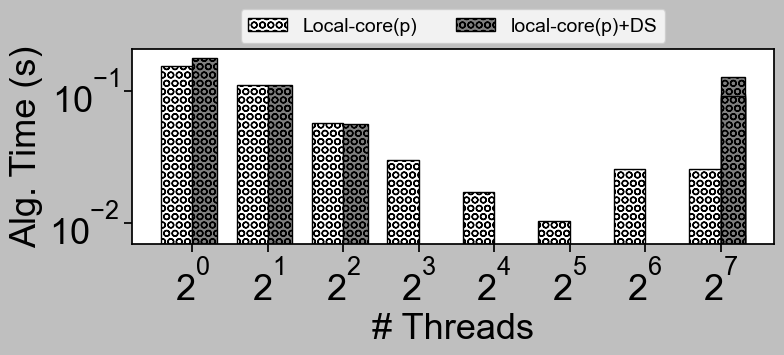

congress
Local-core-OPTIV
8   8
[17.141601  9.97124   4.98202   2.406843  1.388408  0.680377  0.55898
  0.713803]
[14.747403 10.747737  5.561599  2.933565  1.701125  0.981375  0.603865
  0.436503]


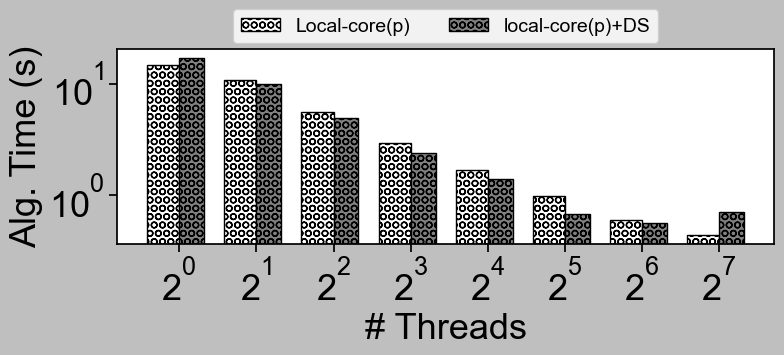

<Figure size 800x400 with 0 Axes>

In [866]:
from matplotlib import pyplot as plt 
from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
sns.set(rc={'figure.figsize':(8,4)})
sns.set_style("ticks")
plt.style.use('grayscale')

save = True

# include_algos = ['LocalP(dyn)']
reference_algs = ['Local-core-OPTIV'] # Reference against.
col = ['r','g','b']
markers = ['o',"s",'x']
group_list = ['dataset']
# include_datasets = ['pref','congress','dblp','gowalla','weeplaces']
# include_datasets = ['bin_2','bin_5','contact','enron', 'congress']
# include_datasets = ['congress','dblp', 'aminer', 'gowalla','pref']
include_datasets = ['dblp', 'aminer', 'pref', 'enron', 'congress']
# include_datasets = ['gowalla']
# columns = ['execution time']

tmp = df[df['dataset'].isin(include_datasets)].copy()
working_df = df[df['dataset'].isin(include_datasets)].copy()
working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df1 = working_df.replace({"dataset": good_name_dataset})

graph = None
df4 = tmp[tmp['algo'].isin(reference_algs)].copy()
df4 = df4.replace({"dataset": good_name_dataset})


# Dynamic lB
tmp = dff[dff['dataset'].isin(include_datasets)].copy()
working_df = dff[dff['dataset'].isin(include_datasets)].copy()
# working_df = working_df[working_df['algo'].isin(include_algos)].copy()
# working_df['param_s'] = working_df['param_s'].astype(int)
working_df = working_df.replace({"algo": good_name_algo})
working_df2 = working_df.replace({"dataset": good_name_dataset})

include_datasets = [good_name_dataset[d] for d in include_datasets]
y_axis = 'execution time'  


# print(df4)
thread_lim = 8
ax = None
ax1 = None
for dp in include_datasets:
    print(dp)
    for i,alg in enumerate(reference_algs):
        print(alg)
        ref_mean = df4[ (df4.algo == alg) & (df4.dataset==dp)]['execution time'].mean()
        # print(df4[ (df4.algo == alg) & (df4.dataset==dp)])
        working_df11 = working_df1[working_df1.dataset == dp].copy()
        working_df22 = working_df2[working_df2.dataset == dp].copy()
        print(len(working_df11),' ',len(working_df22))
        # print(working_df2[y_axis])
        # working_df11['speedup']  = ref_mean/ working_df11[y_axis]
        # working_df22['speedup']  = ref_mean/ working_df22[y_axis]
        # print(working_df22['speedup'])
        if len(working_df11)==0 or len(working_df22) == 0:
            continue 
        # print(working_df2)
        # print(working_df2.groupby(['num_threads'])['execution time'].mean())
        # _min = working_df[y_axis].min()
        # donotdrawline = working_df[y_axis].max() <= 20*_min
        # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
        # graph = sns.barplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # graph = sns.scatterplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind')
        # sns.lineplot(x='num_threads', y=y_axis, hue='algo', data=working_df2, palette='colorblind', marker = markers[i], label = alg)
        # plt.plot(working_df2['num_threads'][:thread_lim], working_df2[y_axis][:thread_lim],marker = markers[i], label = good_name_algo[alg],color = 'k')
        w = working_df11['num_threads'][:thread_lim].values
        w2 = working_df22['num_threads'][:thread_lim].values
        # print(w,w2)
        print(working_df22[y_axis][:thread_lim].values)
        print(working_df11[y_axis][:thread_lim].values)
        ax = plt.bar(x = working_df11['num_threads'][:thread_lim] - w/8, height = working_df11[y_axis][:thread_lim].values, width = w/4,\
                            label = 'Local-core(p)')
        ax1 = plt.bar(x = working_df22['num_threads'][:thread_lim] + w2/8, height = working_df22[y_axis][:thread_lim].values, width = w2/4,\
                            label = 'local-core(p)+DS')
        # for i,v in enumerate(working_df11['num_threads'][:thread_lim]):
        #     speedup = "{:.0f}x".format(ref_mean/ working_df11[y_axis][:thread_lim].values[i])
        #     speedup2 = "{:.0f}x".format(ref_mean/ working_df22[y_axis][:thread_lim].values[i])
        #     # print(working_df2[y_axis][:thread_lim].values[i], speedup)
        #     plt.text(v-working_df11['num_threads'][:thread_lim].values[i]/3.5, working_df11[y_axis][:thread_lim].values[i]*1.1,str(speedup), \
        #              color='k', fontweight='bold',fontsize = fontsize-10) 
        #     plt.text(v, working_df22[y_axis][:thread_lim].values[i]*1.1, str(speedup2), \
        #              color='k', fontweight='bold',fontsize = fontsize-10)
        #     print(speedup,' ',speedup2)

            
        # plt.xticks(working_df2['num_threads'])
        # print(working_df2['num_threads'].values)
        # if i==0:
        # print(working_df2[y_axis])
        # print(working_df2['num_threads'])
        # plt.axhline(ref_mean,color = 'k',linestyle = '--',dashes=(1, 3), label = good_name_algo[alg],linewidth = 3)
        plt.xlabel('# Threads', fontsize=fontsize-2)
        # plt.ylabel("Speedup", fontsize=fontsize)
        plt.ylabel('Alg. Time (s)', fontsize=fontsize-2)
        plt.yscale("log", base = 10)
        plt.xscale("log", base=2)
        plt.xticks(fontsize=fontsize-2)
        plt.yticks(fontsize=fontsize-2)
        
        # plt.ylim(np.min(working_df22[y_axis][:thread_lim].values)/2, np.max(working_df22[y_axis][:thread_lim].values)*2)
        # plt.title(dp)
    for i,thisbar in enumerate(ax.patches):
        thisbar.set_hatch(hatch_dict['LocalP(B+CSR)2'])
        thisbar.set_facecolor('w')
    for i,thisbar in enumerate(ax1.patches):
        thisbar.set_hatch(hatch_dict['LocalP(B+CSR)2'])
        thisbar.set_facecolor('gray')
    # plt.legend(loc = 'upper right', fontsize=labelsize-2)
    plt.legend(loc='upper center', bbox_to_anchor=(0., 1.15, 1., .102), ncol=3, fontsize = labelsize-6)
    ax = plt.gca()
    ax.get_yaxis().set_tick_params(which='minor', size=0)
    ax.get_yaxis().set_tick_params(which='minor', width=0) 
    if (dp=="aminer"):
        ax.set_yticks([10**1,10**2,10**3])
    # if (dp == 'dblp'):
    #     ax.set_yticks([10**0, 10**1,10**2,10**3])
    # plt.ylim(np.min(working_df2[y_axis][:thread_lim].values)/2, np.max(working_df2[y_axis][:thread_lim].values)*1.5)
    plt.tight_layout()
    filename = "parallel_time_"+dp
    if(save):
        plt.savefig("../fig/rev" + filename + ".pdf")
    else:
        print(filename)
    plt.show()
    plt.clf() 
        

    # include_datasets = ['bin_2','bin_5','contact','enron']
    # # columns = ['execution time']
    # working_df = df[df['dataset'].isin(include_datasets)].copy()
    # working_df = working_df[working_df['algo'].isin(include_algos)].copy()
    # # working_df['param_s'] = working_df['param_s'].astype(int)
    # # working_df = working_df.replace({"algo": good_name_algo})
    # working_df = working_df.replace({"dataset": good_name_dataset})
    # include_datasets = [good_name_dataset[d] for d in include_datasets]
    # y_axis = 'execution time'  

    # print(working_df.groupby(['dataset','algo'])['execution time'].mean())
    # # _min = working_df[y_axis].min()
    # # donotdrawline = working_df[y_axis].max() <= 20*_min
    # # working_df[y_axis] = working_df[y_axis].apply(lambda x: [x, 20*_min][x > 20*_min] )  
    # ax = sns.barplot(x='dataset', y=y_axis, hue='algo', data=working_df, palette='colorblind', hue_order = order, order = include_datasets)
    # ax.yaxis.set_major_locator(MaxNLocator(5)) 
    # plt.xlabel('Dataset', fontsize=fontsize)
    # plt.ylabel(good_name[y_axis], fontsize=fontsize)
    # # plt.yscale("log")
    # plt.xticks(fontsize=fontsize)
    # plt.yticks(fontsize=fontsize)
    # # plt.
    # # ()
    # plt.legend(loc = 'upper center', bbox_to_anchor=(0.6,1), fontsize=labelsize-6)
    # plt.tight_layout()
    # filename = ("small " + y_axis).replace(" ", "_")
    # if(save):
    #     plt.savefig("results_final/fig/" + filename + ".pdf")
    # else:
    #     print(filename)
    #     plt.show()
    # plt.clf()


``Impact of Load-balancing``

In [867]:
df_par = pd.read_csv(parallel_outfolder+"results.csv", header = None)
df_par.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
df_par = df_par[df_par.num_threads.isin([1,2,4,8,16,32,64])].copy()
# df_par.head(60)
df_par_nolb = pd.read_csv(parallel_outfolder+"results_nolb.csv", header = None)
df_par_nolb.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"] 
df_tmp = pd.merge(df_par,df_par_nolb,how = 'inner', on=['dataset','num_threads'])
df_tmp['speedup'] = df_tmp['execution time_y']/df_tmp['execution time_x']
selected_df = df_tmp[df_tmp.dataset.isin(['congress','pref','aminer','dblp'])]
selected_df.groupby(by=['dataset'])['speedup'].max()

dataset
aminer      2.043687
congress    1.357787
dblp        2.239172
pref        1.012657
Name: speedup, dtype: float64

`Scalability of the algorithms`

                algo #nodes #edges #nodes/#edges         total
30         bipartite     10      6          10/6  29250.650228
6   Local-core-OPTIV     10      6          10/6    208.183856
7         Local-core     10      6          10/6   1191.172049
8    Local-core-OPTI     10      6          10/6    897.117998
9   Local-core-OPTII     10      6          10/6    514.628750
{'Local-core': {'x': ['10/6', '20/13', '30/19', '40/25', '50/32'], 'y': [1191.172049, 2201.820381, 3423.710324, 4548.475957, 7261.922228]}, 'Local-core-OPTI': {'x': ['10/6', '20/13', '30/19', '40/25', '50/32'], 'y': [897.117998, 1933.41418, 2939.3954360000002, 3797.846711, 5917.2978760000005]}, 'Local-core-OPTII': {'x': ['10/6', '20/13', '30/19', '40/25', '50/32'], 'y': [514.62875, 1238.7146440000001, 1952.055774, 2379.957348, 4030.245768]}, 'Local-core-OPTIII': {'x': ['10/6', '20/13', '30/19', '40/25', '50/32'], 'y': [265.475835, 542.1319579999999, 944.66516, 1293.659046, 1792.781716]}, 'Local-core-OPTIV': {'x': [

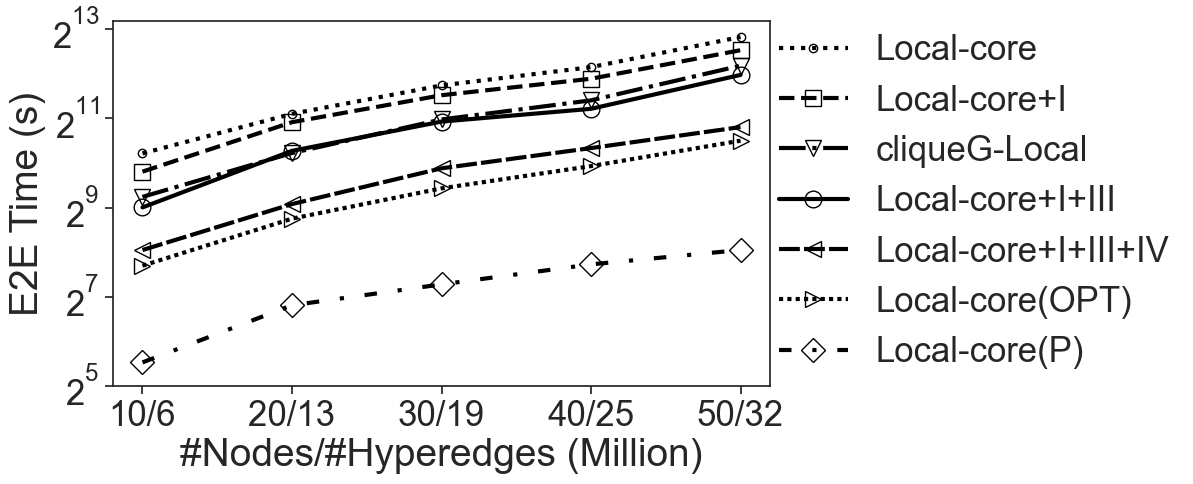

In [3]:
import os 
import pandas as pd 
parpath = "../output/scaloutput/parallel.csv"
seqpath = '../output/scaloutput/sequential.csv'
_edges_dict = {'pref5U_10mil_21_1_300':  "{:.0f}".format(6320622/1000000.0),\
                'pref5U_20mil_21_1_300': "{:.0f}".format(12656553/1000000.0), \
                'pref5U_30mil_21_1_300': "{:.0f}".format(18985950/1000000.0), \
                'pref5U_40mil_21_1_300': "{:.0f}".format(25317585/1000000.0),\
                'pref5U_50mil_21_1_300': "{:.0f}".format(31643941/1000000.0)
                }
df_par = pd.read_csv(parpath,header=None)
df_par.columns = ['algo', 'dataset', 'execution time', 'init time', "num_threads", "total iteration"]
df_seq = pd.read_csv(seqpath,header = None)
df_seq.columns = ['algo', 'dataset', 'execution time','init time', "num_threads", "total iteration"]
df_par['total'] = df_par['execution time'] + df_par['init time']
df_seq['total'] = df_seq['execution time']+df_seq['init time']
df_par['#edges'] = df_par['dataset'].copy(); 
df_par['#edges'] = df_par['#edges'].map(_edges_dict)
df_seq['#edges'] = df_seq['dataset'].copy(); 
df_seq['#edges'] = df_seq['#edges'].map(_edges_dict)
# print(df_seq.head())
df_par['#nodes'] = [str(i.split('_')[1][:2]) for i in df_par.dataset.values]
df_seq['#nodes'] = [str(i.split('_')[1][:2]) for i in df_seq.dataset.values]
df_par['#nodes/#edges'] = df_par['#nodes']+'/'+df_par["#edges"]
df_seq['#nodes/#edges'] = df_seq['#nodes']+'/'+df_seq["#edges"]
df_seq = df_seq[['algo','#nodes','#edges','#nodes/#edges','total']]
df_par = df_par[['algo','#nodes','#edges','#nodes/#edges','total']]
df_seq = df_seq.sort_values(by='#nodes/#edges')
df_par = df_par.sort_values(by='#nodes/#edges')
# df_par.head()
# print([i.split('_')[1] for i in df_par.dataset.values])
# df_seq.head()
df = pd.concat((df_seq , df_par)) 
print(df.head())
# df.shape
# df_seq.shape
# df_par.shape
algos = []
results = {}
for i,j in df.groupby(by=['algo','#nodes/#edges']):
    algo,xlab = i[0],i[1]
    time = j['total'].mean()
    if algo not in results: 
        results[algo] = {'x': [xlab], 'y': [time]}
    else:
        results[algo]['x'].append(xlab)
        results[algo]['y'].append(time)
print(results)
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D,lineStyles
from itertools import cycle
import seaborn as sns 
sns.set(rc={'figure.figsize':(12,5)})
sns.set_style("dark", {'axes.grid' : False})
sns.set_style("ticks")
# plt.style.use('grayscale')
fontsize = 28
labelsize = 20
good_name_algo = {
    'Peel' : "Peel", 
    'E-Peel': "E-Peel", 
    'Local-core': "Local-core",
    'Local-core-OPTI': "Local-core+I",
    'Local-core-OPTII': "Local-core+I+III",
    'Local-core-OPTIII': "Local-core+I+III+IV",
    'Local-core-OPTIV': "Local-core(OPT)",
    'LocalP(B+CSR)2': "Local-core(P)",
    'kdcore': '(k,d)-core',    
    'clique': 'cliqueG-Local',
    'bipartite': 'D2biparatiteG-Local'
}
# algos = ['bipartite', 'Local-core', 'Local-core-OPTI','clique', 'Local-core-OPTII','Local-core-OPTIII',\
#          'Local-core-OPTIV' ,'LocalP(B+CSR)2']
algos = ['Local-core', 'Local-core-OPTI','clique', 'Local-core-OPTII','Local-core-OPTIII',\
         'Local-core-OPTIV' ,'LocalP(B+CSR)2']
# lstyles = list(lineStyles.keys())[:len(algos)]
# lstyles = ['-','--','-.',':']
lstyles = ['dotted','dashed','dashdot','solid',(0,(5,1)),(0,(1,1)),(0, (3, 5, 1, 5))]
markers = ['.','s','v','o','<','>', 'D']
for i,a in enumerate(algos):
    n = results[a]['x']
    ls = lstyles[i % len(lstyles)]
    ms = markers[i%len(markers)]
    # ls = next(lstyles)
    # print(ls)
    plt.plot(results[a]['x'],results[a]['y'],linestyle = ls, \
              fillstyle = 'none',\
             marker = ms, linewidth=3, label = good_name_algo[a],markersize = 12)
lines = plt.gca().get_lines()
[l.set_color('black') for l in lines]

plt.ylabel('E2E Time (s)',fontsize=fontsize)
plt.xlabel('#Nodes/#Hyperedges (Million)',fontsize=fontsize)
# plt.xticks([10,20,30,40,50],fontsize=15)
# plt.xticks(fontsize=fontsize,rotation = 30)
plt.xticks(fontsize=fontsize-3)
plt.yticks(fontsize=fontsize-3)
plt.yscale('log',base = 2)
# plt.yticks([2**(5), 2**7, 2**9, 2**11, 2**13,2**17])
plt.yticks([2**(5), 2**7, 2**9, 2**11, 2**13])
plt.legend(loc = 'upper left', fontsize=fontsize+6, bbox_to_anchor=(0.965,1.05),frameon = False,prop={"size":25})
plt.tight_layout()
plt.savefig('../fig/scalability2.pdf')
plt.show()

In [9]:
# sns.set(rc={'figure.figsize':(8,4)})
# sns.set_style("ticks")
# plt.style.use('grayscale')
# markers = ["o",".","+","x"]
# for i,alg in enumerate(algorithms):
#     plt.plot(cores[alg], cdf[alg],label=alggood_name[alg], marker=markers[i])
#     print(alg,' ',cores[alg][-1])
# # plt.legend()
# plt.xscale('log',base=2)
# plt.xlabel('Core',fontsize=fontsize-2)
# plt.ylabel('%nodes',fontsize=fontsize-2)
# plt.xticks(fontsize=fontsize-2)
# plt.yticks(fontsize=fontsize-2)
# ax = plt.gca()
# ax.get_xaxis().set_tick_params(which='minor', size=0)
# ax.get_xaxis().set_tick_params(which='minor', width=0) 
# plt.legend(loc = 'upper right', fontsize=labelsize)
# plt.tight_layout()
# plt.savefig("../fig/core_distr.pdf")
# plt.show()
# # print(x)
# # print(y)

### Expt-3: Efficiency Analysis of E-Peel vs Peel

In [10]:
# df = pd.read_csv("../output/nbrq_results.csv", header = None,delimiter=' ')
# # df = pd.read_csv("epeel_ana/output/nbrq_results.csv", header = None,delimiter=' ')
# df.columns = ['algo', 'dataset', 'execution time', "n_nbr_q"]
# # df.head()

# include_datasets = ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress', 'aminer']
# epeel_df = df[df.algo == 'E-Peel'].copy()
# epeel_df = epeel_df[epeel_df.dataset.isin(include_datasets)]
# # print(epeel_df)
# peel_df = df[df.algo == 'Peel'].copy()
# peel_df = peel_df[peel_df.dataset.isin(include_datasets)]
# # print(peel_df)
# epeel_df['alpha'] = epeel_df['n_nbr_q'].values/peel_df['n_nbr_q'].values
# epeel_df['Speedup'] = peel_df['execution time'].values/epeel_df['execution time'].values
# print(epeel_df.head(8))

In [11]:
# df = pd.read_csv("../outputold/nbrq_results.csv", header = None,delimiter=' ')
# # df = pd.read_csv("epeel_ana/output/nbrq_results.csv", header = None,delimiter=' ')
# df.columns = ['algo', 'dataset', 'execution time', "n_nbr_q"]
# # df.head()

# include_datasets = ['bin_5','dblp', 'enron', 'bin_2','contact', 'congress', 'aminer', 'pref']
# epeel_df = df[df.algo == 'E-Peel'].copy()
# # print(epeel_df)
# peel_df = df[df.algo == 'Peel'].copy()
# # print(peel_df)
# epeel_df['alpha'] = epeel_df['n_nbr_q'].values/peel_df['n_nbr_q'].values
# epeel_df['Speedup'] = peel_df['execution time'].values/epeel_df['execution time'].values
# print(epeel_df.head(8))

In [12]:
# import matplotlib.pyplot as plt 
# # from matplotlib.lines import Line2D
# # from matplotlib.ticker import MaxNLocator
# import seaborn as sns 
# sns.set(rc={'figure.figsize':(8,4)})
# # sns.set_style("whitegrid", {'axes.grid' : False})
# sns.set_style("ticks")
# plt.style.use('grayscale')

# epeel_df = epeel_df.sort_values('alpha')
# # epeel_df = epeel_df.replace({"algo": good_name_algo})
# epeel_df = epeel_df.replace({"dataset": good_name_dataset})
# # marker_list = list(Line2D.markers)
# marker_list = [',', '.', 'o', 'v', '^', '<', '>','X','8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', ]
# print(marker_list[:len(epeel_df)])
# ax = sns.scatterplot(x='alpha', y='Speedup', data=epeel_df, style='dataset', markers = marker_list[:len(epeel_df)], s= 135)
# # plt.xticks([0.3,0.7,0.9,0.95,1.1])
# ax.set_xlabel(r"${\alpha}$", fontsize=fontsize)
# ax.set_ylabel("Speedup",fontsize= fontsize)
# plt.xticks(fontsize=fontsize-8)
# plt.yticks(fontsize=fontsize-6)
# # plt.legend(loc = 'best', fontsize=labelsize-4, markerscale=2, mode = "expand", ncol = 4)
# plt.legend(loc = 'upper left', fontsize=labelsize-4, bbox_to_anchor=(0.95,1))
# plt.tight_layout()
# plt.savefig('../fig/Epeel_exp.pdf')

In [13]:
# epeel_df.head()